# On Deck ML Challenge
## Goals
- Build the first iteration of a recommender system that could suggest top-recommended movies to users.
- Provide a GitHub repo (private is fine) with the working model and some description of how to reproduce training/testing steps.
- Provide written answers to these questions:
  - A brief justification of the chosen model and the scoring metric. What alternatives would be worth exploring?
  - What would be your next steps to improve the recommendation quality?

[Dataset link](https://www.dropbox.com/s/vi7lktdxx0r97o4/od-challenge.tar.gz?dl=1).

## Notes

- You define the technical details of the solution: the model, feature set, test/train split, normalization, loss, scoring metric.
- You're not expected to use as much features as possible. Explore the data and take what works best for your approach.
- You're not expected to produce a model with perfect scores. It's enough to pick a sensible model, make a few tweak iterations, produce some results, and outline a path to improve it.

## Technical constraints

- Python 3.8+, Torch/TensorFlow/Keras.
- The model, the traing and testing code should be in Jupyter notebooks. Everything else may be in notebooks or python files.
- If trainng takes more than an hour on a laptop, provide the trained model and the code to load it.

## 1. Import Libraries and Dataset

In [1]:
# All imports will be declared here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
aggs=pickle.load(open('./data/aggs.pickle', 'rb'))
labels=pickle.load(open('./data/labels.pickle', 'rb'))
movies=pickle.load(open('./data/movies.pickle', 'rb'))
teams=pickle.load(open('./data/teams.pickle', 'rb'))

In [4]:
files = [aggs, labels, movies, teams]
names = ['aggs', 'labels', 'movies', 'teams']
for f, fname in zip(files, names):
    f.to_csv(f'./data/{fname}.csv', index=False)

## 2. Data Preprocessing and Exploratory Data Analysis

### Aggregated Ratings

In [3]:
aggs.head()

,movie_id,rating_average,rating_count,demographic
0,109830,8.8,1870499,total
1,109830,8.8,1032446,gender_m
2,109830,8.7,269593,gender_f
3,109830,8.9,1215,age_0_17
4,109830,8.9,344804,age_18_29


In [4]:
aggs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28557 entries, 0 to 28556
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        28557 non-null  object 
 1   rating_average  28557 non-null  float64
 2   rating_count    28557 non-null  object 
 3   demographic     28557 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.1+ MB


In [5]:
aggs.describe()

,rating_average
count,28557.000000
mean,6.802889
std,0.992756
min,1.000000
25%,6.200000
50%,6.900000
75%,7.500000
max,10.000000


### User Ratings

In [6]:
labels.head()

,movie_id,user_id,rating
1,116367,1,3.0
3,114287,1,5.0
4,109370,1,5.0
5,112851,1,5.0
6,112508,1,5.0


In [7]:
labels.describe()

,movie_id,user_id,rating
count,4.223700e+04,42237.000000,42237.000000
mean,3.872995e+05,303.150200,3.610318
std,6.451020e+05,177.654595,1.063750
min,4.170000e+02,1.000000,0.500000
25%,1.004050e+05,144.000000,3.000000
50%,1.186360e+05,305.000000,4.000000
75%,3.502580e+05,454.000000,4.500000
max,6.644200e+06,610.000000,5.000000


In [8]:
labels.movie_id.value_counts()

111161    200
109830    189
110912    183
102926    163
133093    147
         ... 
424880      2
446046      2
455857      2
125971      2
345549      2
Name: movie_id, Length: 4107, dtype: int64

In [9]:
labels.user_id.value_counts()

279    150
247    149
7      147
41     147
80     146
      ... 
53      14
245     14
207     14
324     14
544     12
Name: user_id, Length: 610, dtype: int64

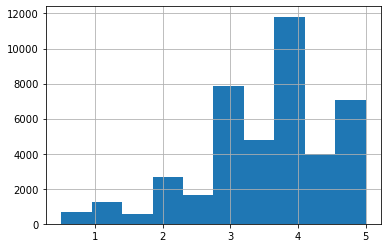

In [10]:
labels.rating.hist()

### Cast & Crew

In [11]:
teams.head()

,movie_id,person_role,person_id,person_name
0,109830,actor,158,
1,109830,actor,705,
2,109830,actor,641,
3,109830,actor,398,
4,109830,actor,931508,


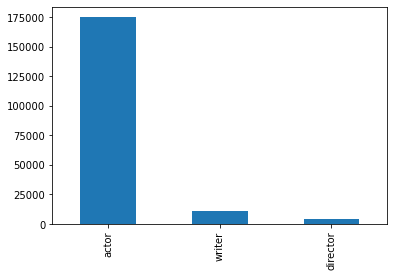

In [12]:
teams.person_role.value_counts().plot.bar()

In [13]:
teams.movie_id.value_counts()

401711     134
1333125    133
374463     115
362120     110
1300854    109
          ... 
83652        3
104361       3
832903       2
59026        2
248808       2
Name: movie_id, Length: 4107, dtype: int64

### Movies Info

In [14]:
movies.head()

,movie_id,title,genres,year,synopsis
0,114709,Toy Story,"{Adventure, Animation, Children, Fantasy, Comedy}",1995,A boy called Andy Davis (voice: John Morris) u...
1,113497,Jumanji,"{Adventure, Children, Fantasy}",1995,The film begins in 1869 in the town of Brantfo...
2,113277,Heat,"{Action, Crime, Thriller}",1995,An inbound Los Angeles Blue Line train pulls i...
3,114319,Sabrina,"{Romance, Comedy}",1995,"Sabrina Fairchild (Julia Ormond), is the Larra..."
4,112302,Tom and Huck,"{Adventure, Children}",1995,The film opens with Injun Joe (Eric Schweig) a...


In [15]:
movies['genres']=movies.genres.astype(str).apply(lambda x: x.replace('{', '').replace('}', ''))

In [16]:
movies_genres=movies.genres.str.get_dummies(',')
movies_genres

,'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir',...,'Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'
0,0,0,1,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4102,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4103,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4104,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4105,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


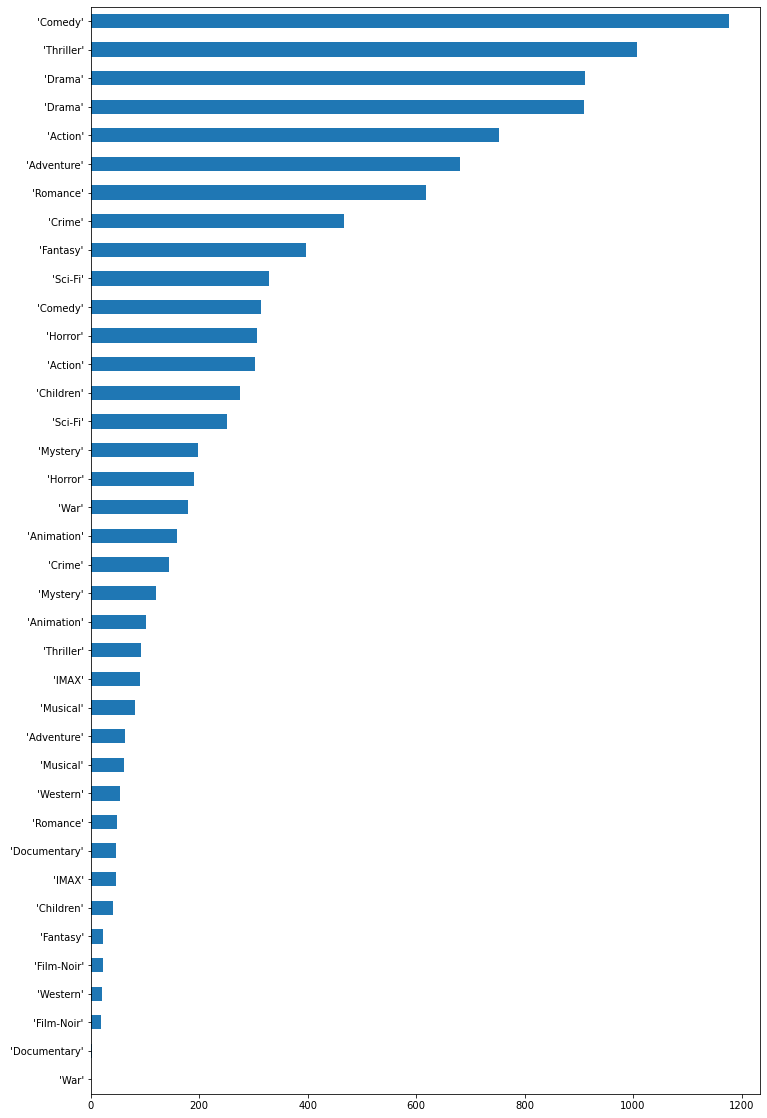

In [17]:
movies_genres.sum().sort_values().plot.barh(figsize=(12, 20))

In [18]:
movies=pd.concat([movies.drop('genres', axis=1), movies_genres], axis=1)
movies.head()

,movie_id,title,year,synopsis,'Action','Adventure','Animation','Children','Comedy','Crime',...,'Film-Noir','Horror','IMAX','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'
0,114709,Toy Story,1995,A boy called Andy Davis (voice: John Morris) u...,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,113497,Jumanji,1995,The film begins in 1869 in the town of Brantfo...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,113277,Heat,1995,An inbound Los Angeles Blue Line train pulls i...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,114319,Sabrina,1995,"Sabrina Fairchild (Julia Ormond), is the Larra...",0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,112302,Tom and Huck,1995,The film opens with Injun Joe (Eric Schweig) a...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## 3. Recommender System

We have multiple possibilities here ([ref1](https://www.kaggle.com/ibtesama/getting-started-with-a-movie-recommendation-system), [ref2](https://developers.google.com/machine-learning/recommendation/)):
### Demographic Filtering
Offer generalized recommendations to every user, based on movie popularity and/or genre. The System recommends the same movies to users with similar demographic features. The basic idea behind this system is that movies that are more popular and critically acclaimed will have a higher probability of being liked by the average audience.
- Pros
  - Simplicity
- Cons
  - Since each user is different , this approach is considered to be *too* simple. 

### Content Based Filtering
They suggest similar items based on a particular item. This system uses item metadata, such as genre, director, description, actors, etc. for movies, to make these recommendations. The general idea behind these recommender systems is that if a person liked a particular item, he or she will also like an item that is similar to it.
- Pros
  - The model doesn't need any data about other users, since the recommendations are specific to this user. This makes it easier to scale to a large number of users.
  - The model can capture the specific interests of a user, and can recommend niche items that very few other users are interested in.
- Cons
  - Since the feature representation of the items are hand-engineered to some extent, this technique requires a lot of domain knowledge. Therefore, the model can only be as good as the hand-engineered features.
  - The model can only make recommendations based on existing interests of the user. In other words, the model has limited ability to expand on the users' existing interests


### Collaborative Filtering
This system matches persons with similar interests and provides recommendations based on this matching. 
  - Pros
    - Collaborative filters do not require item metadata like its content-based counterparts.
    - The model can help users discover new interests. In isolation, the ML system may not know the user is interested in a given item, but the model might still recommend it because similar users are interested in that item.
    - To some extent, the system needs only the feedback matrix to train a matrix factorization model. In particular, the system doesn't need contextual features. In practice, this can be used as one of multiple candidate generators.
  - Cons
    - The [cold start problem](https://en.wikipedia.org/wiki/Cold_start_(recommender_systems))
    - Does not use meaninful information from metadata. However, although not simple, we can [augment the input matrix with features](https://developers.google.com/machine-learning/recommendation/collaborative/summary). 

Since one of our requirements is to use a deep learning library, let's explore a Colaborative Filtering approach. Even though there's the cold start problem, we can match new users by asking them their top 3 favorite movies and match with with the movie embedding that has been built after training the network. Alternative strategies such as projections and heuristics are available in [this reference](https://developers.google.com/machine-learning/recommendation/collaborative/summary)

In [ ]:
from sklearn.model_selection import train_test_split
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model